---
# Classifying Alzeihmer's Dementia MRI Brain Scans
## Jason Lu, Juan Marcucci, Dan Rossetti
---
---

# NOTEBOOK 1
---
---

# 0 - Imports

In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

# Set this to maintain a constant random state everywhere
#  Help with this import:  https://www.tensorflow.org/tutorials/quickstart/advanced
# import tensorflow as tf

# Help with this from:  https://www.tensorflow.org/api_docs/python/tf/random/set_seed
#tf.random.set_seed(42)

# Source provided by Eric Bayless for help with this:  
#  https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
# tf.keras.utils.set_random_seed(42)
seed = 42

import random
import tensorflow as tf
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 1 - Connect to Github, Read Data

## 1.1 - Clone Github Repo, cd into 'data' Folder

In [ ]:
# Clear out the directory in case you run the code top to bottom.
!rm -r ga_project_4/

# Inspiration to do this from:  https://stackoverflow.com/questions/65386157/importing-images-from-github-to-colab
# Code help from:  https://neptune.ai/blog/google-colab-dealing-with-files
!git clone https://github.com/drossDS/ga_project_4.git

Cloning into 'ga_project_4'...
remote: Enumerating objects: 6442, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 6442 (delta 4), reused 12 (delta 1), pack-reused 6424
Receiving objects: 100% (6442/6442), 151.66 MiB | 17.92 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
# Help with this code to cd into folders from:  
#  https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter
%cd ga_project_4/
%cd data/
!ls

/content/ga_project_4
/content/ga_project_4/data
archive_binary.zip  archive.zip


## 1.2 - Unzip the Data and Explore the Images in Each class

In [ ]:
# Unzip data
!unzip -q archive.zip

(176, 208)


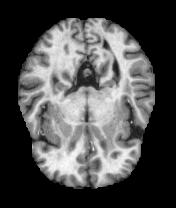

In [ ]:
# Let's look at one of the images
brain_image = load_img('/content/ga_project_4/data/Alzheimer_s Dataset/train/NonDemented/nonDem0.jpg')

# Code help with images size:  https://machinelearningmastery.com/how-to-load-convert-and-save-images-with-the-keras-api/
print(brain_image.size)

# View the image
brain_image

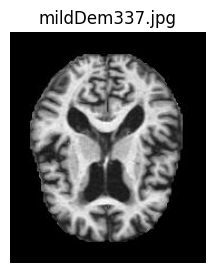

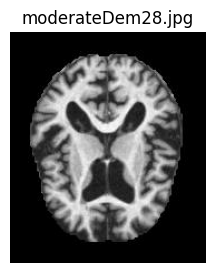

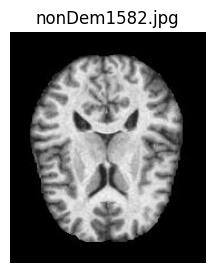

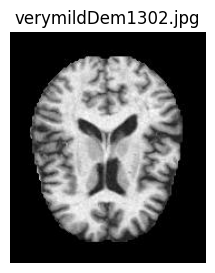

In [ ]:
# Write a loop to show one image from each class

# Create a list of top-level folders, and second level folders
top_lev = ['train']
second_lev = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Store the base file path:
base_path = '/content/ga_project_4/data/Alzheimer_s Dataset'

# Create a for loop that goes through train and test
for folder_1 in top_lev:

  # Create loop that goes through all the category folders
  for folder_2 in second_lev:

    # Loop through the images in each folder, but only look at the first one in the list
    for file in [os.listdir(base_path + '/' + folder_1 + '/' + folder_2)[0]]:

      # Show each 
      brain_image = load_img(base_path + '/' + folder_1 + '/' + folder_2 + '/' + file)

      # The following code was inspired by:  https://stackoverflow.com/questions/67083671/trying-to-have-matplotlib-set-the-title-as-whatever-input-i-choose-for-ticker-pa
      plt.figure(figsize = (3, 3))
      plt.imshow(brain_image)
      plt.title(file)
      plt.axis('off')
      plt.show()

In [ ]:
# Write a loop to check all the pixel sizes

# Create an empty list to store all the image sizes
image_sizes = []

# Create a list of top-level folders, and second level folders
top_lev = ['test', 'train']
second_lev = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Store the base file path:
base_path = '/content/ga_project_4/data/Alzheimer_s Dataset'

# Create a for loop that goes through train and test
for folder_1 in top_lev:

  # Create loop that goes through all the category folders
  for folder_2 in second_lev:

    # Loop through the images in each folder
    for file in os.listdir(base_path + '/' + folder_1 + '/' + folder_2):

      # Store each brain image to a temporary variable
      brain_image = load_img(base_path + '/' + folder_1 + '/' + folder_2 + '/' + file)

      # Get the image size from the temporary variable and append to the list
      image_sizes.append(brain_image.size)

# Ensure that there are 6400 images and that all loops ran properly
print(len(image_sizes))

# Flatten the list to a set to get unique images sizes, check size...there should be only one
set(image_sizes)

6400


{(176, 208)}

# 2 - Create Training and Validation Datasets, Import Testing Dataset

In [ ]:
# Create the training dataset using a 90/10 train/validation split
train_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/train',
    image_size = (176, 208),
    batch_size = 32,
    seed = 42,
    validation_split = 0.1,
    subset = 'training',
    label_mode = 'categorical',
    
)

val_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/train',
    image_size = (176, 208),
    batch_size = 32,
    seed = 42,
    validation_split = 0.1,
    subset = 'validation', 
    label_mode = 'categorical',
)

'''
The testing dataset will be imported in a similar manner, but
does not need to be batched or split.  So some of the arguments input
previously will not need to be called
'''
test_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/test',
    image_size = (176, 208),
    label_mode = 'categorical',
)

Found 5121 files belonging to 4 classes.
Using 4609 files for training.
Found 5121 files belonging to 4 classes.
Using 512 files for validation.
Found 1279 files belonging to 4 classes.


# 3 - Initial Modeling

In [ ]:
'''
Here a function is being defined which will extract and format the target data from the 
BatchDataset and then format it into an array of numbers that provide the class numbers.

It will optionally convert this to a pandas series for pandas operations (like .value_counts()).
'''

def target_extractor(data_array, series=False):

  # Source for help with the following line of code to extract classes:
  #  https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
  '''
  The list comprehension produces a list which is then turned into a numpy array with concatenate.  Note that
  an array of 1 x 4 arrays is created, with 4 probabilties of belonging to each class.
  '''
  y = np.concatenate([y for x, y in data_array], axis=0)
  
  '''
  The following argument takes the resulting array containing only probabilities of belonging
  to each class, determines which is the largest probability class, and replaces the entire
  1 x 4 array with a number corresponding to the highest probability class.  This soure was
  helpful wiht this:  
  https://stackoverflow.com/questions/68836551/keras-attributeerror-sequential-object-has-no-attribute-predict-classes
  '''
  y = np.argmax(y, axis = 1)

  # Make y a pandas array for when .value_counts needs to be called
  if series == True:
    y = pd.Series(y)

  return y

## 3.1 - Establish Null Model

In [ ]:
# Find the value counts of each class using the function created
target_extractor(train_ds, series=True).value_counts(normalize = True)

2    0.497288
3    0.350401
0    0.142330
1    0.009980
dtype: float64

#### OBSERVATIONS:
* The classes are represented as numbers representing the folders in their (alphabetical) order:
  * Class 0 is Mild Dementia
  * Class 1 is Moderate Dementia
  * Class 2 is No Dementia
  * Class 3 is Very Mild Dementia
* The largest class at nearly 50% is the no dementia class. Thus the null model would be to assume that the image does not have dimentia and that model would be correct nearly 50% of the time


# 3.15 Class Weights

In [ ]:
# https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99
from sklearn.utils.class_weight import compute_class_weight

def generate_class_weights(class_series):
  y = np.concatenate([y for x, y in class_series], axis=0)
  class_series = np.argmax(y, axis=1)
  class_labels = np.unique(class_series)
  class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
  return dict(zip(class_labels, class_weights))

In [ ]:
class_weights = generate_class_weights(train_ds)
n_classes = len(class_weights)

In [ ]:
class_weights

{0: 1.7564786585365855,
 1: 25.04891304347826,
 2: 0.5027268760907504,
 3: 0.7134674922600619}

## 3.2 - Run Initial Convolutional Neural Network Model

In [ ]:
# Instantiate the sequential model
model = Sequential()

# Input later is needed for the model summary
model.add(layers.Input(shape=(176, 208, 3)))
# Rescaling layer - which basically divides everything by 255 to get
#  the values between 0 and 1
model.add(layers.Rescaling(1./255)) 

# Convolutional and pooling layer
model.add(Conv2D(64, (3,3), activation = 'relu')) # 'kernel' and 'filter' are synonymous
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional and pooling layer
model.add(Conv2D(64, (3,3), activation = 'relu')) # 'kernel' and 'filter' are synonymous
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))

# Output
model.add(Dense(4, activation = 'softmax'))

# Compile it
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Fit it
res_cnn = model.fit(train_ds,
                    class_weight = class_weights,
                    epochs = 15,
                    batch_size = 64,
                    validation_data = val_ds,
                    verbose = 1)

Epoch 1/15
145/145 [==============================] - 12s 48ms/step - loss: 1.4984 - acc: 0.1725 - val_loss: 1.3870 - val_acc: 0.3457
Epoch 2/15
145/145 [==============================] - 7s 50ms/step - loss: 1.3855 - acc: 0.3161 - val_loss: 0.9950 - val_acc: 0.5332
Epoch 3/15
145/145 [==============================] - 7s 50ms/step - loss: 1.2376 - acc: 0.4496 - val_loss: 0.9574 - val_acc: 0.6055
Epoch 4/15
145/145 [==============================] - 7s 47ms/step - loss: 0.5632 - acc: 0.7177 - val_loss: 0.4539 - val_acc: 0.8145
Epoch 5/15
145/145 [==============================] - 7s 50ms/step - loss: 0.2156 - acc: 0.8811 - val_loss: 0.2345 - val_acc: 0.9258
Epoch 6/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0988 - acc: 0.9481 - val_loss: 0.1433 - val_acc: 0.9434
Epoch 7/15
145/145 [==============================] - 7s 47ms/step - loss: 0.0321 - acc: 0.9863 - val_loss: 0.0681 - val_acc: 0.9785
Epoch 8/15
145/145 [==============================] - 7s 49ms/step -

In [ ]:
'''
Create a funciton which will plot the final and best training and validation accuracies on a given model.
'''

def acc_printer(model):
  # Print the training and testing accuracies
  print(f"Final Model Accuracy on Training Data:  {model.history['acc'][-1]}")
  print(f"Final Model Accuracy on Validation Data:  {model.history['val_acc'][-1]}")

  print(f"Best Model Accuracy on Training Data:  {model.history['acc'][np.argmax(model.history['acc'])]}")
  print(f"Best Model Accuracy on Validation Data:  {model.history['val_acc'][np.argmax(model.history['val_acc'])]}")

In [ ]:
# Print the training and testing accuracies
acc_printer(res_cnn)

Final Model Accuracy on Training Data:  1.0
Final Model Accuracy on Validation Data:  0.99609375
Best Model Accuracy on Training Data:  1.0
Best Model Accuracy on Validation Data:  0.99609375


In [ ]:
# Get the model predictions
preds = model.predict(test_ds)

# Convert the model predicitons into an array with class values
preds_arr = np.argmax(preds, axis = 1)
print(preds_arr.shape)
preds_arr

40/40 [==============================] - 1s 31ms/step
(1279,)


array([3, 2, 3, ..., 3, 3, 2])

In [ ]:
# Create a y_test array from test_ds that can be compared to the predictions
y_test = target_extractor(test_ds)
print(y_test.shape)
y_test

(1279,)


array([2, 3, 2, ..., 2, 2, 2])

Model Accuracy on Test Data: 0.38702111024237684 



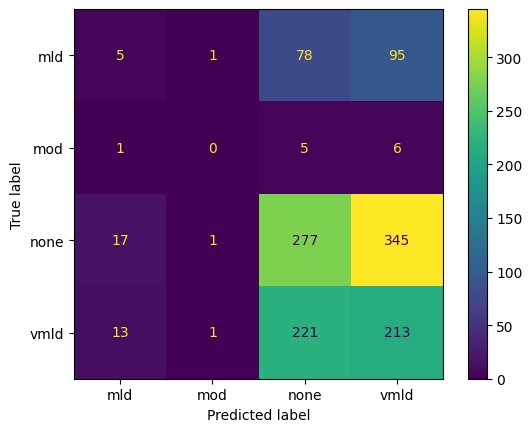

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_arr)

# Help relabeling the axes from:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
plt.xticks([0,1,2,3], ['mld', 'mod', 'none', 'vmld'])
plt.yticks([0,1,2,3], ['mld', 'mod', 'none', 'vmld']);
print(f'Model Accuracy on Test Data: {accuracy_score(y_test, preds_arr)} \n')

In [ ]:
# Help with this code from:  https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2
print(classification_report(y_test, preds_arr, target_names = ['mild', 'noderate', "none", 'very_mild']))

              precision    recall  f1-score   support

        mild       0.14      0.03      0.05       179
    noderate       0.00      0.00      0.00        12
        none       0.48      0.43      0.45       640
   very_mild       0.32      0.48      0.38       448

    accuracy                           0.39      1279
   macro avg       0.23      0.23      0.22      1279
weighted avg       0.37      0.39      0.37      1279



#### OBSERVATIONS:
* The overall model accuracy on the test data is much lower than on the training and validation data at approximately 40% (given that the neural network results vary from run to run)
* From the confusion matrix, the model appears to be confusing the no dementia and very mild dementia images

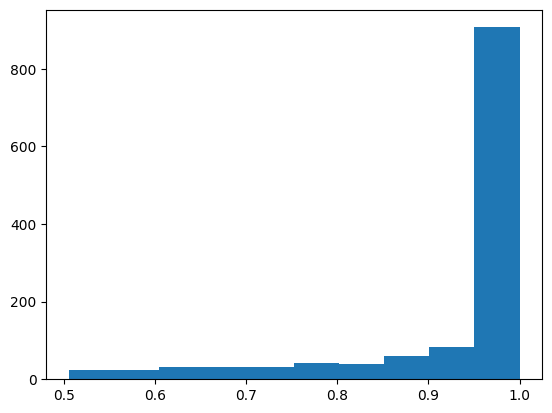

In [ ]:
'''
Here, it is useful to have an understanding of probability distribution of the predictions.
The maximum probability for each class determines which class is the predicted class.
With each succesive run of the model, it is conceivalbe that images with lower probability
predictions would be more volatile and could more easily change classes as the model is 
re-run.  Having very many probabilities closer to 50% could indicate that many predictions
are highly susceptible to model variations with each run.
'''
plt.hist(preds.max(axis = 1));